## RUN ONCE ~ CREATE VIRTUAL ENV

In [ ]:
from google.colab import drive
from os.path import join
import sys

def mount_drive(ROOT):
    drive.mount(ROOT, force_remount=True)

ROOT = '/content/drive'
mount_drive(ROOT)

MY_GOOGLE_DRIVE_PATH = 'MyDrive/RL_NLP/PPO_NEW/NLP_RL_Docker_Version'
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)
print("PROJECT_PATH: ", PROJECT_PATH)
%cd "{PROJECT_PATH}"
sys.path.insert(0, PROJECT_PATH)

Mounted at /content/drive
PROJECT_PATH:  /content/drive/MyDrive/RL_NLP/PPO_NEW/NLP_RL_Docker_Version
/content/drive/MyDrive/RL_NLP/PPO_NEW/NLP_RL_Docker_Version


In [ ]:
!pip3 install virtualenv
!virtualenv myenv
!source myenv/bin/activate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 40.6 MB/s eta 0:00:00
created virtual environment CPython3.10.12.final.0-64 in 15367ms
  creator CPython3Posix(dest=/content/drive/MyDrive/RL_NLP/PPO_NEW/NLP_RL_Docker_Version/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.1.2, setuptools==68.0.0, wheel==0.40.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [ ]:
!pip install -r "{PROJECT_PATH}/metadata/requirements.txt"
!pip install -r "{PROJECT_PATH}/metadata/requirements1.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.1 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.0
    Uninstalling pygame-2.5.0:
      Successfully uninstalled pygame-2.5.0


In [ ]:
!pip install -e .

Obtaining file:///content/drive/MyDrive/RL_NLP/PPO_NEW/NLP_RL_Docker_Version
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!deactivate

/bin/bash: deactivate: command not found


## RUN FROM HERE.

In [ ]:
from google.colab import drive
from os.path import join
import sys

def mount_drive(ROOT):
    drive.mount(ROOT, force_remount=True)

ROOT = '/content/drive'
mount_drive(ROOT)

MY_GOOGLE_DRIVE_PATH = 'MyDrive/RL_NLP/PPO_NEW/NLP_RL_Docker_Version'
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)
print("PROJECT_PATH: ", PROJECT_PATH)
%cd "{PROJECT_PATH}"
sys.path.insert(0, PROJECT_PATH)

In [ ]:
# Doesn't work because collab uses different shell than virtualenv !source myenv/bin/activate
!pip install transformers
!mkdir results

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.1 MB/s eta 0:00:00
mkdir: cannot create directory ‘results’: File exists


In [ ]:
import numpy as np
import pandas as pd
import time
import utils as U
import model as M
import model_nlp as MNLP
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import copy
import gym
import sys
import os
sys.path.append(f'{os.getcwd()}/gym-examples')
import gym_examples
import numpy as np
import json


suffix = [['easy','medium','hard','naive'],['fnlp_easy','fnlp_medium','fnlp_hard','fnlp_naive']]

In [ ]:
def plot_ppo(name):
    arr=[]
    with open(f'results/test_reward_list_{name}.json', 'r') as file:
        arr=json.load(file)
        x,y=[arr[i][0] for i in range(len(arr))], [arr[i][1] for i in range(len(arr))]
        plt.plot(x,y)
        plt.xlabel(f'Frame Number')
        plt.ylabel(f'Cumulative Reward')
        plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def run_best_env(number,name):
    str_arr = name.split('_')
    opt = 0
    if 'fnlp' in str_arr:
        opt = 1
    def policy(S):
        nonlocal opt
        if opt == 0:
            dist, value = model(S['visual'])
        elif opt == 1:
            dist, value = model(S['visual'],S['text'])
        action = dist.sample()
        return action.cpu().numpy().item()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if opt == 0:
        model = M.NNModel().to(device)
    elif opt == 1:
        model = MNLP.NNModelNLP().to(device)
    model.load_state_dict(torch.load(f'results/model_{name}.ml'))
    dbg=True
    episodes=1
    env = gym.make('gym_examples/RlNlpWorld-v0',render_mode="rgb_array")
    for _ in range(episodes):
        cumulative_reward,steps=0,0
        observation = env.reset(set_no=number,seed=42)
        state = copy.deepcopy(observation)
        observation['state'] = U.pre_process(observation)
        if opt == 1:
            observation['text'] = U.pre_process_text(model,observation)
        while True:
            print(observation['text'])
            if dbg==True:
                plt.imshow(state['visual'])
                plt.show()
            action = policy(observation)  # User-defined policy function
            observation, reward, terminated, info = env.step(action)
            print(f'Action {action}')
            state = copy.deepcopy(observation)
            observation['state'] = U.pre_process(observation)
            if opt == 1:
                observation['text'] = U.pre_process_text(model,observation)
            cumulative_reward += reward
            steps += 1
            if terminated: break
        print(f'Cumulative Reward ~ {cumulative_reward}; TimeTaken ~ {steps}')
    env.close()

### Best Agent

In [ ]:
def best_env(number=1):
    f,s,t = number//100,(number%100)//10,number%10
    exp_action = [0,3]*f + [1,4]*s + [2,5]*t
    exp_action_indx = 0
    def human_policy(observation):
        nonlocal exp_action_indx
        # action=int(input())
        try:
            action = exp_action[exp_action_indx]
            exp_action_indx += 1
        except Exception as e:
            action = -1
        return action
    dbg=True
    episodes=1
    env = gym.make('gym_examples/RlNlpWorld-v0',render_mode="rgb_array")
    for _ in range(episodes):
        cumulative_reward,steps=0,0
        observation = env.reset(set_no=number)
        cnt,mx_iter=0,1002
        while steps<mx_iter:
            print(observation['text'])
            if dbg==True:
                plt.imshow(observation['visual'])
                plt.show()
            action = human_policy(observation)  # User-defined policy function
            print(action)
            observation, reward, terminated, info = env.step(action)
            cumulative_reward+=reward
            steps+=1
            if dbg==True:
                print(f'cumulative_reward {cumulative_reward}; action {action}')
            if terminated:
                break
        print(f'Cumulative Reward ~ {cumulative_reward}; TimeTaken ~ {steps}')
    env.close()

This is one. Let's use our blocks to build the number. To build one , pick up the first unit block .


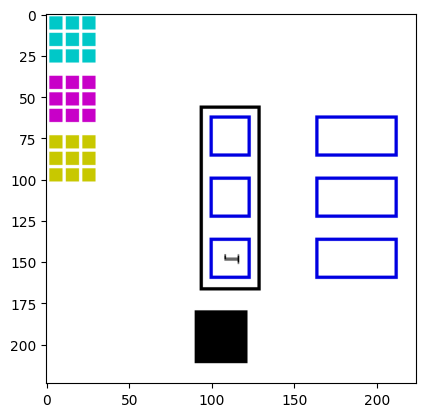

2
cumulative_reward 1; action 2
Put the unit block in the unit's palce .


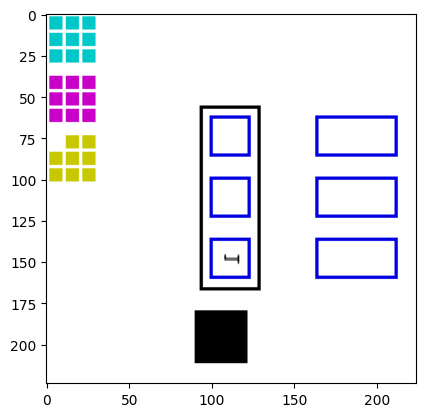

2
cumulative_reward -1; action 2
Put the unit block in the unit's palce .


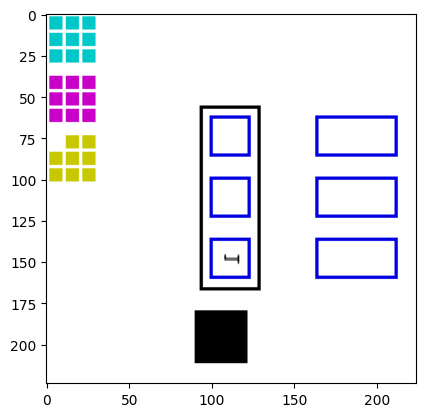

2
cumulative_reward -3; action 2
Put the unit block in the unit's palce .


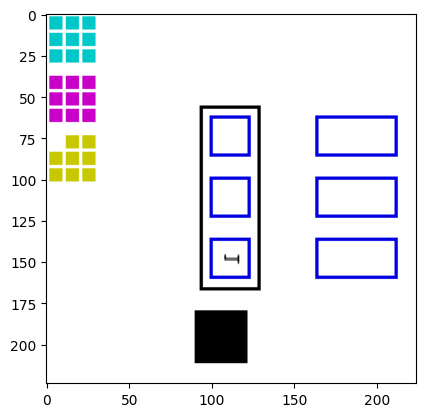

2
cumulative_reward -5; action 2
Put the unit block in the unit's palce .


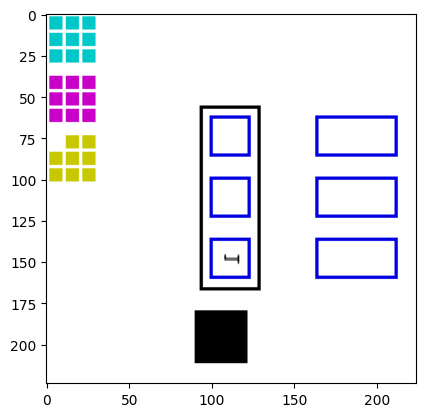

2
cumulative_reward -7; action 2
Put the unit block in the unit's palce .


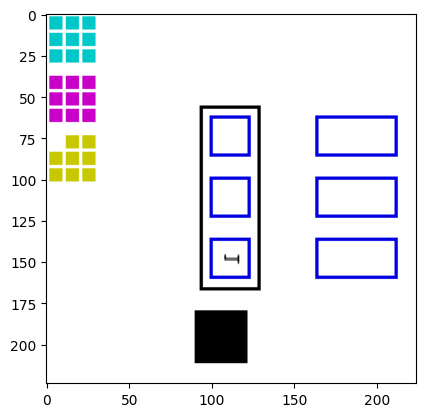

2
cumulative_reward -17; action 2
Cumulative Reward ~ -17; TimeTaken ~ 6


In [ ]:
best_env()

In [ ]:
!python3 -W ignore ppo.py --model 0 --ease -1 --log 20

2023-07-19 07:35:10,378 - ppo.py:177 - Number of Episodes Tr[0]*50 = 1000
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/referen

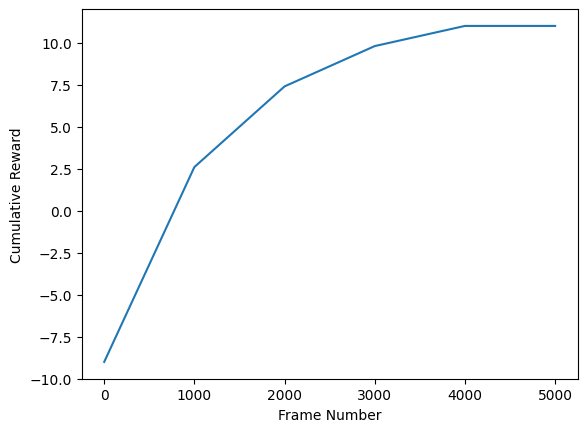

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: Deprecat

This is one. Let's use our blocks to build the number. To build one , pick up the first unit block .


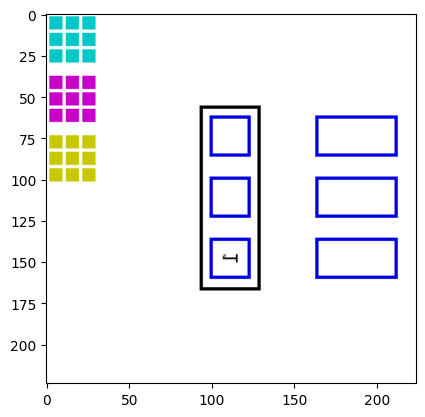

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Action 2
Put the unit block in the unit's palce .


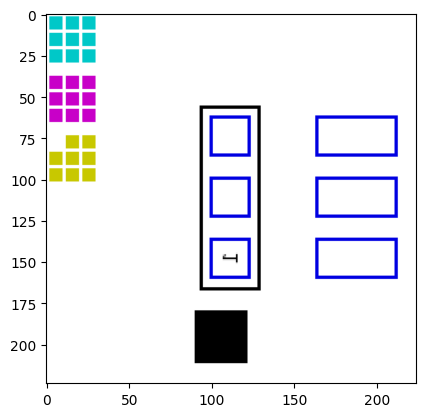

Action 5
Cumulative Reward ~ 11; TimeTaken ~ 2


In [ ]:
plot_ppo(suffix[0][-1])
run_best_env(1,suffix[0][-1])

In [ ]:
!python3 -W ignore ppo.py --model 1 --ease -1 --log 20

2023-07-19 08:16:33,119 - ppo.py:177 - Number of Episodes Tr[0]*50 = 1000
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/referen

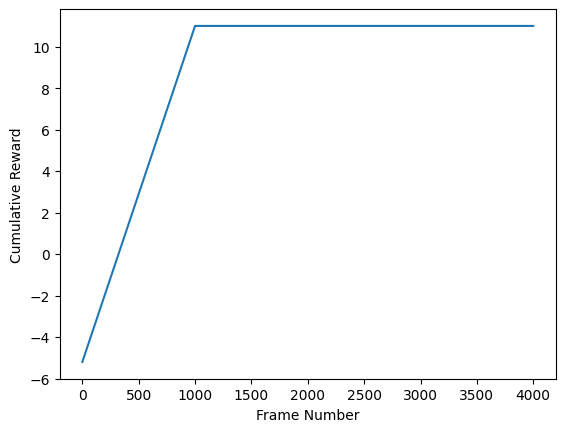

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: Deprecat

{'input_ids': tensor([[ 101, 2023, 2003, 2028, 1012, 2292, 1005, 1055, 2224, 2256, 5991, 2000,
         3857, 1996, 2193, 1012, 2000, 3857, 2028, 1010, 4060, 2039, 1996, 2034,
         3131, 3796, 1012,    0,    0,    0,    0,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}


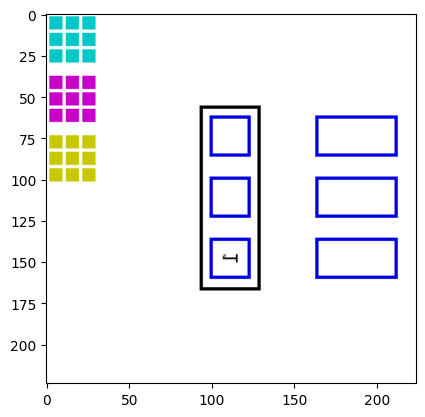

Action 2
{'input_ids': tensor([[  101,  2404,  1996,  3131,  3796,  1999,  1996,  3131,  1005,  1055,
         14412,  3401,  1012,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}


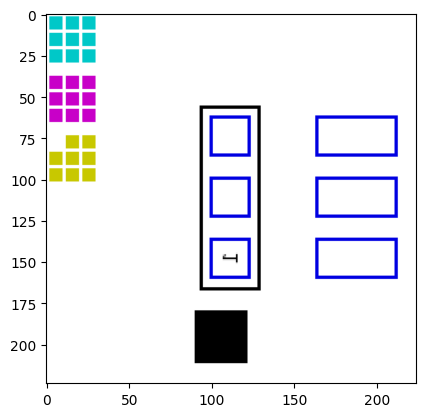

Action 5
Cumulative Reward ~ 11; TimeTaken ~ 2


In [ ]:
plot_ppo(suffix[1][-1])
run_best_env(1,suffix[1][-1])

## Run more difficult tasks.

In [ ]:
!python3 -W ignore ppo.py --model 0 --ease 0

In [ ]:
plot_ppo(suffix[0][0]) # Plot training set.

arr = []
with open(f'results/test_set{suffix[0][0]}.json', 'r') as file:
    arr=json.load(file)

run_best_env(arr[-1],suffix[0][0]) # See the performance on the most difficult number.

In [ ]:
!python3 -W ignore ppo.py --model 1 --ease 0

/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr

In [ ]:
plot_ppo(suffix[1][0]) # Plot training set.

arr = []
with open(f'results/test_set{suffix[0][0]}.json', 'r') as file:
    arr=json.load(file)

run_best_env(arr[-1],suffix[1][0]) # See the performance on the most difficult number.